### Problem Statement

A retail company 'ABC Private Limited' wants to understand the customer purchase behaviour (specifically,
purchase amount) against various products of different categories. They have shared purchase summary of 
various customers for selected high volume products from last month.

The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city),
product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which 
will help them to create personalized offer for customers against different products.

---

### Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('./train.csv')

In [3]:
print ('The dataset only has null values in the multi-category columns. \n', data.isnull().sum(axis = 0))

The dataset only has null values in the multi-category columns. 
 User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64


In [4]:
print ('There are ', data.groupby('User_ID').User_ID.nunique().count(), ' unique users and ',\
                     data.groupby('Product_ID').Product_ID.nunique().count(), ' unique products.') 
print ('\n')

print ('Users have ', data.groupby('Occupation').Occupation.nunique().count(), ' unique occupations.')

print ('\n')

print ('Age is given as a range: ', data['Age'].unique())

print ('\n')

print ('There are ', data.groupby('City_Category').City_Category.nunique().count(),\
                      ' unique city categories.')

There are  5891  unique users and  3631  unique products.


Users have  21  unique occupations.


Age is given as a range:  ['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']


There are  3  unique city categories.


Only 42% of our dataset is married.


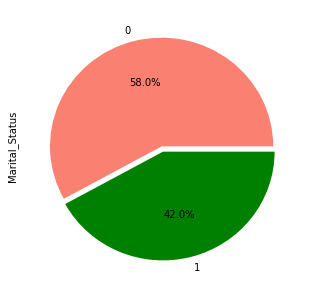

In [5]:
print ('Only 42% of our dataset is married.')

plt.rcParams['figure.figsize'] = 5,5

Marriage = pd.DataFrame(data.groupby('User_ID').Marital_Status.mean())
Marriage['Marital_Status'].value_counts().plot.pie(autopct='%1.1f%%', shadow=False, explode = (0, 0.05),\
                                          colors=['salmon', 'green'])
plt.show()
del Marriage

The average transaction value is $ 9263.97 .
The average user transacts  93.37  times.


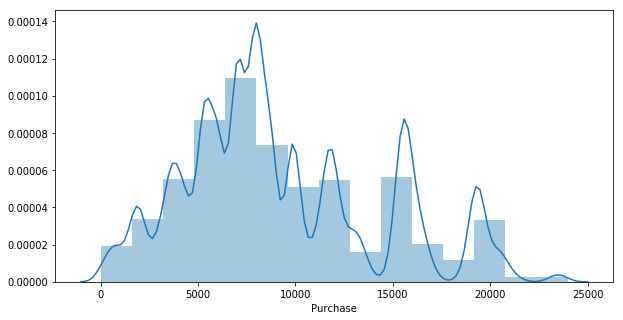

In [6]:
print ('The average transaction value is $', round(data['Purchase'].sum() / data['User_ID'].count(),2), '.')
print ('The average user transacts ', round(data['Purchase'].count() / data['User_ID'].nunique(),2), ' times.')

plt.rcParams['figure.figsize'] = 10,5
sns.distplot(data['Purchase'], bins=15)
plt.show()

City, Gender, Age, and Occupation seem to have little to no effect on purchase price. We can see that the majority of transactions are roughly $7,500.


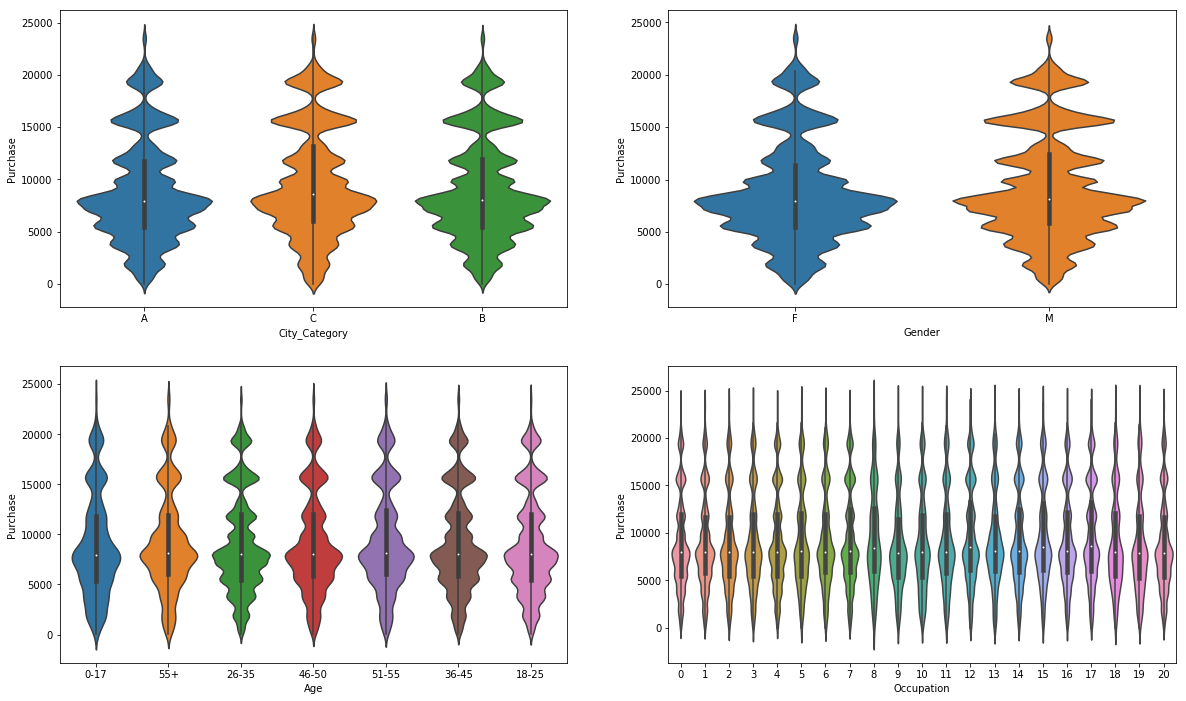

In [7]:
print ('City, Gender, Age, and Occupation seem to have little to no effect on purchase price. \
We can see that the majority of transactions are roughly $7,500.')
f, ax = plt.subplots(2,2, figsize=(20,12))
sns.violinplot(data=data, x='City_Category', y='Purchase', ax=ax[0,0])
sns.violinplot(data=data, x='Gender', y='Purchase', ax=ax[0,1])
sns.violinplot(data=data, x='Age', y='Purchase', ax=ax[1,0])
sns.violinplot(data=data, x='Occupation', y='Purchase', ax=ax[1,1])
plt.show()

No strong correlation between variables. Strongest is marital status and age.


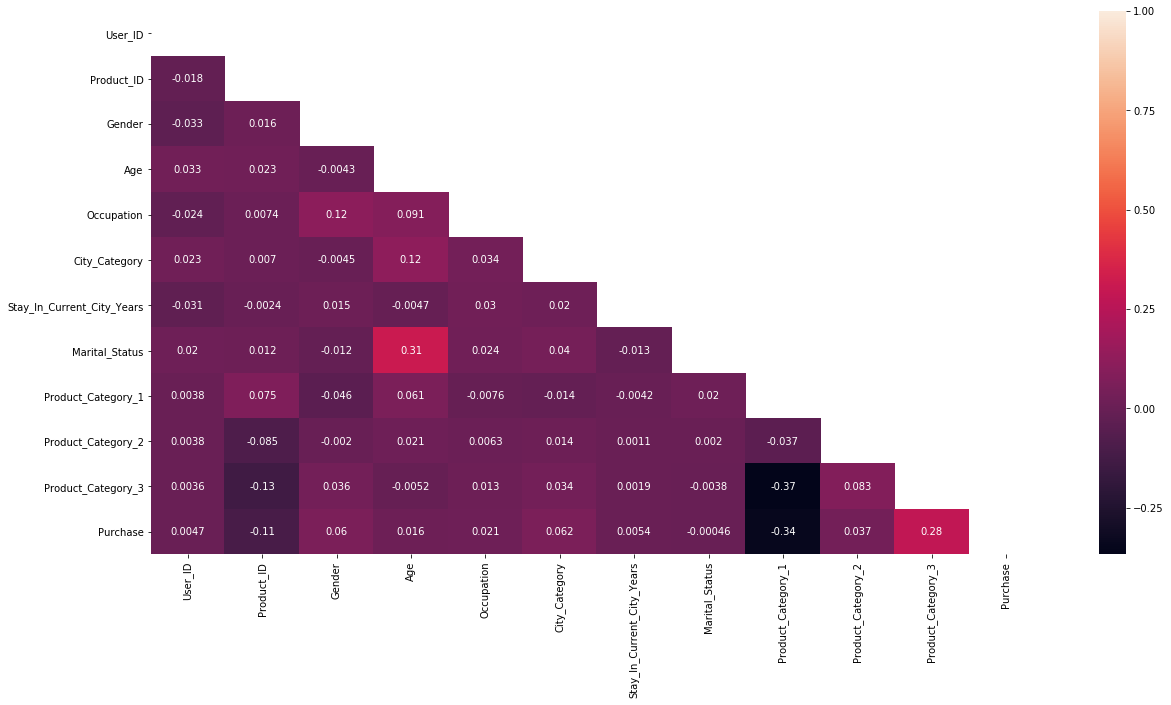

In [8]:
print ('No strong correlation between variables. Strongest is marital status and age.')

dataTemp = data
catCols = dataTemp.columns.drop('Purchase')

for x in catCols:
    dataTemp[x] = dataTemp[x].astype('category').cat.codes


plt.rcParams['figure.figsize'] = 20,10
cor = dataTemp.corr()
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True


x = sns.heatmap(cor, annot=True, mask=mask)
plt.setp(x.get_yticklabels(), rotation=360)
plt.show()

del dataTemp

---

### Feature Engineering

In [9]:
data = pd.read_csv('./train.csv')

fill = ['Product_Category_2', 'Product_Category_3']
for x in fill:
    data[fill] = data[fill].fillna(0)

In [10]:
print ('This function checks to see if a product is in multiple categories, then creates a total count \
of categories column.')

prodCols = ['Product_Category_1', 'Product_Category_2', 'Product_Category_3']

for x in prodCols:
    data[x + '_Val_Check'] = data[x].notnull().astype(int)
    
valCountCols = data.filter(regex="_Val_Check")
data['Total_Product_Cat_Count'] = valCountCols.sum(axis=1)

This function checks to see if a product is in multiple categories, then creates a total count of categories column.


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

catCols = ['Gender', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Product_ID']
for i in catCols:
    data[i] = le.fit_transform(data[i])
    
categoricalCols = data.columns.drop(['Purchase', 'Total_Product_Cat_Count'])
for col in categoricalCols:
    data[col] = data[col].astype('category')

---

### Modeling

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 

plt.rcParams['figure.figsize'] = 10,7.5

In [13]:
cols = data.columns
cols = cols.drop(['Purchase'])

X = data[cols]
y = data['Purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [14]:
mod = []
lr = LinearRegression()
mod.append(lr)
lasso = linear_model.Lasso()
mod.append(lasso)
bay = linear_model.BayesianRidge()
mod.append(bay)
forest_reg = RandomForestRegressor()
mod.append(forest_reg)
grad_boost = GradientBoostingRegressor()
mod.append(grad_boost)

model_names = ['LinearRegression', 'Lasso', 'BayesianRidge', 'RandomForestRegressor', 'GradientBoostingRegressor']
rmse = []
r2 = []

for i in mod:
    i.fit(X_train, y_train)
    pred = i.predict(X_test)
    model_mse = mean_squared_error(pred, y_test)
    rmse.append(np.sqrt(model_mse))
    r2.append(i.score(X_test, y_test))
    
model_scores = pd.DataFrame(columns={'Model', 'R2', 'RMSE'})
model_scores['Model'] = model_names
model_scores['R2'] = r2
model_scores['RMSE'] = rmse

print ('Create a loop to test each model and print their results. The RandomForestRegressor has the highest R2, which\
is how close the data fits the regression line. Additionally, it has the lowest random mean squared error which is the\
 standard deviation of the residuals.')
model_scores.sort_values(by=['R2', 'RMSE'], ascending=False)

Create a loop to test each model and print their results. The RandomForestRegressor has the highest R2, whichis how close the data fits the regression line. Additionally, it has the lowest random mean squared error which is the standard deviation of the residuals.


,R2,RMSE,Model
3,0.677709,2849.456319,RandomForestRegressor
4,0.660884,2922.886813,GradientBoostingRegressor
1,0.151701,4622.881090,Lasso
2,0.151698,4622.887685,BayesianRidge
0,0.151696,4622.893448,LinearRegression


RandomForestRegressor has the most normal distribution of residuals.


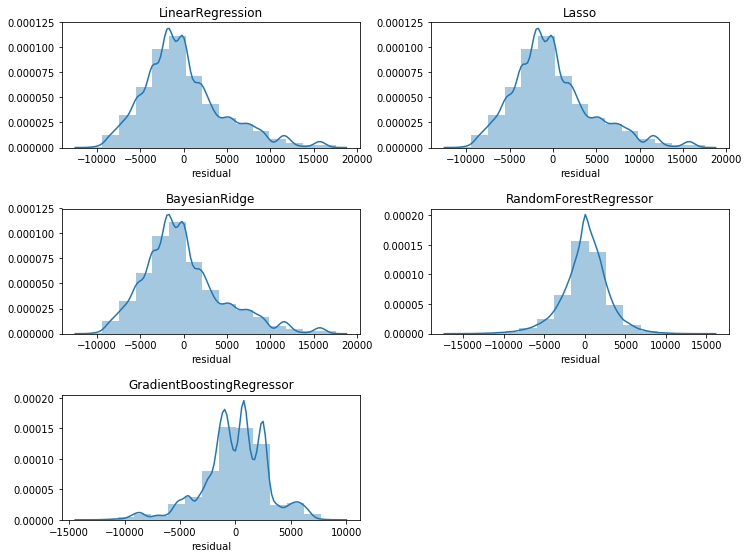

In [15]:
model_names_df = [i + '_df' for i in model_names]

for x in range(0,5):
    z = mod[x].predict(X_test)
    model_names_df[x] = pd.DataFrame( { 'actual': y_test,
                                    'predicted': np.round( z, 2),
                                    'residual': y_test - z } )
    
model_names = ['LinearRegression', 'Lasso', 'BayesianRidge', 'RandomForestRegressor', 'GradientBoostingRegressor']
    
f, ax = plt.subplots(3,2)
f.tight_layout(h_pad=4, w_pad=4)

a = sns.distplot(model_names_df[0]['residual'], bins=15, ax=ax[0,0]).set_title(model_names[0])
b = sns.distplot(model_names_df[1]['residual'], bins=15, ax=ax[0,1]).set_title(model_names[1])
c = sns.distplot(model_names_df[2]['residual'], bins=15, ax=ax[1,0]).set_title(model_names[2])
d = sns.distplot(model_names_df[3]['residual'], bins=15, ax=ax[1,1]).set_title(model_names[3])
e = sns.distplot(model_names_df[4]['residual'], bins=15, ax=ax[2,0]).set_title(model_names[4])
f.delaxes(ax.flatten()[5])
print ('RandomForestRegressor has the most normal distribution of residuals.')
plt.show()

In [26]:
print ('Now that we have chosen the most accurate model, we will pass parameter args to improve our model.')

forest_reg = RandomForestRegressor(n_jobs=-1, n_estimators=100, max_features='auto', warm_start=True)
forest_reg.fit(X_train, y_train)
print ('Model Score: ', forest_reg.score(X_test, y_test))

Now that we have chosen the most accurate model, we will pass parameter args to improve our model.
Model Score:  0.7011576912770893
